# Prostate-cANcer-graDe-Assessment

## Introduction

With more than 1 million new diagnoses reported every year, prostate cancer (PCa) is the second most common cancer among males worldwide that results in more than 350,000 deaths annually. The key to decreasing mortality is developing more precise diagnostics. Diagnosis of PCa is based on the grading of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the Gleason grading system. In this challenge, you will develop models for detecting PCa on images of prostate tissue samples, and estimate severity of the disease using the most extensive multi-center dataset on Gleason grading yet available.

The grading process consists of finding and classifying cancer tissue into so-called Gleason patterns (3, 4, or 5) based on the architectural growth patterns of the tumor (Fig. 1). After the biopsy is assigned a Gleason score, it is converted into an ISUP grade on a 1-5 scale. The Gleason grading system is the most important prognostic marker for PCa, and the ISUP grade has a crucial role when deciding how a patient should be treated. There is both a risk of missing cancers and a large risk of overgrading resulting in unnecessary treatment. However, the system suffers from significant inter-observer variability between pathologists, limiting its usefulness for individual patients. This variability in ratings could lead to unnecessary treatment, or worse, missing a severe diagnosis.

Automated deep learning systems have shown some promise in accurately grading PCa. Recent research, including two studies independently conducted by the groups hosting this challenge, have shown that these systems can achieve pathologist-level performance. However, these systems/results were not tested with multi-center datasets at scale.

Link: https://www.kaggle.com/c/prostate-cancer-grade-assessment?utm_medium=social&utm_source=twitter&utm_campaign=pandas-social-launch

# PART1 - Pre-Image Processing

In this part, we will convert all TIFF image - in which are very big, into JPG format after process of cropping & scale-down

In [19]:
#Step:1 - Convert TIFF into JPG
import os
from shutil import copyfile
import cv2

#Create new folder for JPG images
os.mkdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train')
os.mkdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/cv')
os.mkdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/test')

#List of all TIFF images
imgList = os.listdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train_images')
print("Total images amount: ", len(imgList))

Total images amount:  10616


In [2]:
#Step:2 - Crop & Resize
import tifffile

imgList = os.listdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train_images')
imgList = imgList[4000:8000]
srcPath = "G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train_images/"
dstPath = "G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/"
for i, value in enumerate(imgList):
    img = tifffile.imread(srcPath + value)
    imgloc = dstPath + value[:- 4] + 'jpg'
    tifffile.imsave(imgloc, img)
    
    #Validate files
    file_size = os.stat(imgloc).st_size
    if  file_size > 966367641:
        os.remove(imgloc)
    if os.path.exists(imgloc):
        if cv2.imread(imgloc) is None:
            os.remove(imgloc)
        else:     
            #Crop & Resize
            img = cv2.imread(imgloc, cv2.IMREAD_UNCHANGED)
            #Reduce maxX axis
            height, width, channels = img.shape
            x1 = width - 20
            x2 = width
            while True:
                #if np.unique(img[:,x1:x2], return_counts=True)[0] == 255:
                if (img[:,x1:x2] == 255).all():
                    img = img[:,0:x1]
                x2 -=20
                x1 -= 20
                if x1 <= 0:
                    break

            #Reduce maxY axis
            height, width, channels = img.shape
            x1 = height - 20
            x2 = height
            while True:
                #if np.unique(img[x1:x2,:], return_counts=True)[0] == 255:
                if (img[:,x1:x2] == 255).all():
                    img = img[0:x1,:]
                x2 -=20
                x1 -= 20
                if x1 <= 0:
                    break

            #cv2.imwrite(file, output)
            width = img.shape[1]
            height = img.shape[0]

            # dsize
            dsize = (200, 174)

            # resize image
            output = cv2.resize(img, dsize)
            cv2.imwrite(imgloc, output) 

            #validate if file is too small 2KB
            file_size = os.stat(imgloc).st_size
            if  file_size < 4000:
                os.remove(imgloc)

## Image Classification

Since, the submission is based on isup_grade, we need to classify our image according to 2 parameters:
### A. Gleason Score - as followed:
- Gleason score 6 = ISUP grade 1
- Gleason score 7 (3 + 4) = ISUP grade 2
- Gleason score 7 (4 + 3) = ISUP grade 3
- Gleason score 8 = ISUP grade 4
- Gleason score 9-10 = ISUP grade 5.
- no cancer in the sample, ISUP grade 0

### B. Data provider - in which conatins2 types: redboud & karolinska

In [3]:
#Step:3 - Load Dataset
import nbconvert
import pandas as pd
train_df = pd.read_csv("G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train.csv")
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
train_df['gleason_score'].unique()

array(['0+0', '4+4', '3+3', '4+3', 'negative', '4+5', '3+4', '5+4', '5+5',
       '5+3', '3+5'], dtype=object)

In [5]:
#Step:4 - remove 'negative' values
#Calc neg value percentage
print(len(train_df[train_df['gleason_score'] == 'negative']) / len(train_df))

#Remove neg
train_df = train_df[train_df['gleason_score'] != 'negative']

0.09108892238131122


In [7]:
#Step:5 - Create class folders
import os
providerList = train_df['data_provider'].unique()
gleasonPriList = train_df['isup_grade'].unique() #for thos step can can use isup ot gleaons; we will use isup for ease on process

#Create class folders
#Create class folders
for i, valueA in enumerate(providerList):
    os.mkdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/' + valueA)
    os.mkdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/cv/' + valueA)
        
for i, valueA in enumerate(providerList):
    for j, valueB in enumerate(gleasonPriList):
        os.mkdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/' + valueA + '/' + str(valueB))
        os.mkdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/cv/' + valueA + '/' + str(valueB))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/karolinska'

In [13]:
#Step:6 - split images into calss
import shutil
def splitFunc(value):
    tmp = train_df[train_df['image_id'] == value]
    #print(tmp)
    # Split for train
    srcPath = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/'
    srcFile = srcPath + value + ".jpg"
    split = list(tmp['gleason_score'].str.rsplit("+", expand=True)[0].iloc[0])
    split.append(tmp['gleason_score'].str.rsplit("+", expand=True)[1].iloc[0])
    provider = list(tmp['data_provider'])
    if split[0] == split[1]:
        # Split provider
        if provider[0] == 'karolinska':
            dstPath = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/karolinska/' + split[0] + '/'
            dstFile = dstPath + value + ".jpg"
            shutil.copyfile(srcFile, dstFile)
            os.remove(srcFile)
        else:
            dstPath = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/radboud/' + split[0] + '/'
            dstFile = dstPath + value + ".jpg"
            shutil.copyfile(srcFile, dstFile)
            os.remove(srcFile)
    else:
        if provider[0] == 'karolinska':
            dstPath = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/cv/karolinska/' + split[0] + '/'
            dstFile = dstPath + value + ".jpg"
            shutil.copyfile(srcFile, dstFile)
            os.remove(srcFile)
        else:
            dstPath = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/cv/radboud/' + split[0] + '/'
            dstFile = dstPath + value + ".jpg"
            shutil.copyfile(srcFile, dstFile)
            os.remove(srcFile)
    return

In [14]:
import os
filesList = list(train_df['image_id'])
for i, value in enumerate(filesList):
    Path = 'G:\\DataScienceProject\\Kaggle-Prostate-cANcer-graDe-Assessment\\train\\'
    File = Path + value + ".jpg"
    if os.path.exists(File):
        splitFunc(value)
        #print(File)
    else:
        pass

# PART2 - Machine Learning

In this part, we will do machine learning in to steps: 
- Image classification according to Gleason score for identify isup by FastAI
- Combine image classification prediction with other machine learning to give accurate predition.

In [1]:
#Step:7 - FASTAI
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')
path = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train'
folderList = os.listdir(path)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  test="../cv",
                                  valid_pct=0.2,
                                  classes=folderList)

In [2]:
#Step:8 - Check accuricy over iteration 
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=accuracy)
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,2.313645,2.145405,0.366667,00:13
1,2.220741,1.857935,0.333333,00:12
2,2.097021,1.714341,0.293333,00:12
3,2.006867,1.643391,0.346667,00:12
4,1.921284,1.553931,0.426667,00:12
5,1.810355,1.448193,0.413333,00:12
6,1.682223,1.385191,0.440000,00:12
7,1.568499,1.343088,0.493333,00:12
8,1.445279,1.321336,0.513333,00:12
9,1.331589,1.337713,0.520000,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


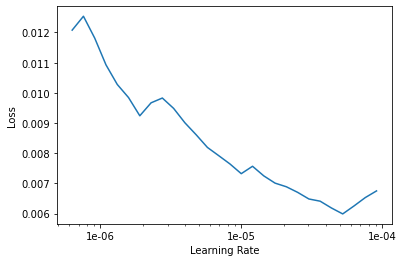

In [3]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(100, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.000565,3.024274,0.600000,00:17
1,0.000472,3.045355,0.606667,00:12
2,0.000350,3.031986,0.600000,00:12
3,0.000255,3.045607,0.600000,00:12
4,0.000278,3.034278,0.600000,00:13
5,0.000224,3.048603,0.600000,00:13
6,0.000185,3.025454,0.593333,00:12
7,0.000173,2.939198,0.620000,00:12
8,0.000165,2.945187,0.633333,00:12
9,0.000186,2.948459,0.640000,00:12


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


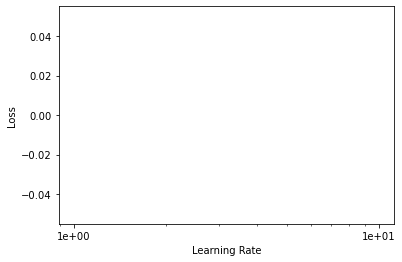

In [5]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [13]:
#Step:9 - Cleansing images
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [14]:
#Step:10 - Check miscalssification
df = pd.read_csv('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/cleaned.csv', header='infer')
df['class'] = df.name.str.rsplit("\\", expand=True)[0]
if (df['class'].all() != df['label'].all()) == True:
    os.remove('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/cleaned.csv')
    os.remove('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/models/tmp.pth')
    os.rmdir('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/models')
else:
    print("!!!miscalssification!!!")

OSError: [WinError 145] The directory is not empty: 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train/models'

In [15]:
#Finalize model
path = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/train'
folderList = os.listdir(path)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  test="../cv",
                                  valid_pct=0.2,
                                  classes=folderList)

epoch,train_loss,valid_loss,accuracy,time
0,0.743925,0.550405,0.933333,00:12
1,0.703301,0.535279,0.933333,00:13
2,0.698656,0.522564,0.940000,00:19
3,0.655337,0.481910,0.940000,00:15
4,0.599008,0.418382,0.940000,00:14
5,0.518240,0.360218,0.940000,00:14
6,0.441459,0.287422,0.940000,00:13
7,0.371441,0.250931,0.940000,00:14
8,0.310056,0.241318,0.933333,00:14
9,0.264926,0.299459,0.920000,00:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.008712,0.429379,0.926667,00:14
1,0.004889,0.425997,0.926667,00:15
2,0.004624,0.413103,0.926667,00:14
3,0.004307,0.420445,0.920000,00:14
4,0.003321,0.427064,0.920000,00:13
5,0.003758,0.445336,0.920000,00:15
6,0.003006,0.452038,0.920000,00:15
7,0.003874,0.521036,0.913333,00:15
8,0.004571,0.645195,0.900000,00:15
9,0.006522,0.665968,0.893333,00:14


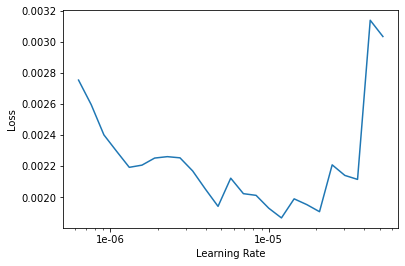

In [16]:
#learn.load('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/fastai-new2')
learn.data = data
learn.freeze()
learn.fit_one_cycle(51)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(51, max_lr=slice(3e-5, 3e-4))
learn.save('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/fastai-test')

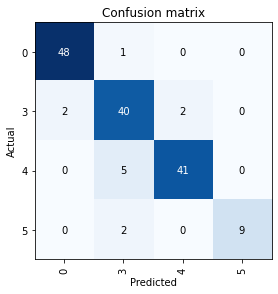

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [47]:
#Load test dataset
test_df = pd.read_csv('G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/test.csv')
testList = list(test_df['image_id'])
test_df['isup_grade'] = 0
test_df['gleason_score'] = '0+0'

for i, value in enumerate(testList):
    file = 'G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/test/' + value + '.jpg'
    img = open_image(file)
    pred_class, pred_idx, output = learn.predict(img)
    output = output.tolist()
    
    #Calc gleaon pri & sec
    for j, valuea in enumerate(output):
         if valuea < 0.05:
            valuea = 0
            output[j] = valuea

    #Pri gleason:
    pri = output.index(max(output))
    if pri == 1:
        pri = 3
    elif pri == 2:
        pri = 4
    elif pri == 3:
        pri = 5
    output.remove(max(output))
    
    #Second
    if max(a) != 0:
        sec = output.index(max(output))
        if pri == 1:
            pri = 3
        elif pri == 2:
            pri = 4
        elif pri == 3:
            pri = 5
    else:
        sec = pri

    test_df['gleason_score'].loc[i] = str(pri) + "+" + str(sec)
    
    #ISUP Calc
    if pri == 0 and sec ==0:
        test_df['isup_grade'].loc[i] = 0
    elif pri == 3 and sec ==4:
        test_df['isup_grade'].loc[i] = 2
    elif pri == 4 and sec ==3:
        test_df['isup_grade'].loc[i] = 3
    elif pri + sec == 8:
        test_df['isup_grade'].loc[i] = 4
    elif pri + sec > 8:
        test_df['isup_grade'].loc[i] = 5
    elif pri == 4 and sec ==0:
        test_df['isup_grade'].loc[i] = 4
    elif pri == 5 and sec ==0:
        test_df['isup_grade'].loc[i] = 5
    else:
        test_df['isup_grade'].loc[i] = 1

##save csv
submission = test_df
submission.drop(['data_provider', 'gleason_score'],inplace=True,axis=1)
submission.to_csv("G:/DataScienceProject/Kaggle-Prostate-cANcer-graDe-Assessment/submission1.csv", index=False)